## Suppl. Fig4: Faceted volcano plots

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent / "data"
sys.path.append(str(script_path))
from utils.volcano import load_volcano_data

output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

plt.rcParams['pdf.fonttype'] = 42

### Load data

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")

Timestamp: 2023-10-21-imp5-for-figures


In [3]:
# define files to load
enrichment_dir = Path.cwd().parent.parent / "enrichment"
volcano_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f'{timestamp}_volcano_table.csv'
clusters_csv = Path.cwd().parent.parent / "Fig2" / "panel_C" / "output" / f"{timestamp}_graph-based_annotations.csv"
try:
    # load the file
    volcano_df, ip_name_with_comparts, Gene_name_canonical, cluster_highlights = load_volcano_data(volcano_csv_path, clusters_csv)
except FileNotFoundError:
    print(f"One or more of the following files are not found:\n{volcano_csv_path}\n{clusters_csv}\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {volcano_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
# check cluster_highlights are in cluster_annotation
# cluster_highlights is a list clusters names to highlight in each pulldown
cluster_labels = volcano_df[("metadata", "consensus_graph_annnotation")].unique()
for i in cluster_highlights:
    for j in i:
        print(f"{j} not in consensus_graph_annnotation") if j not in cluster_labels else None

### Set up a grid of subplots

In [5]:
# number of sub plots
print(f"number of subplots: {len(ip_name_with_comparts)}")
nrows = 7
ncols = 6
print(f"nrows: {nrows}, ncols: {ncols}")

number of subplots: 37
nrows: 7, ncols: 6


### Fill the grid of subplots

In [6]:
# settings
fig_width = 17  # inch (2x letter width 8.5)
fig_height = 22  # inch (2x letter height 11)
rest_points_color = "#d6d4d4"
plt.rcParams["pdf.fonttype"] = 42  # for illustrator
rasterized_points = True  # rasterize the datapoints, or else import to illustrator will be very slow

# highlight colors, old color: #fc8c03
colors_list = ["#E66100", "#0C7BDC", "#40B0A6"]

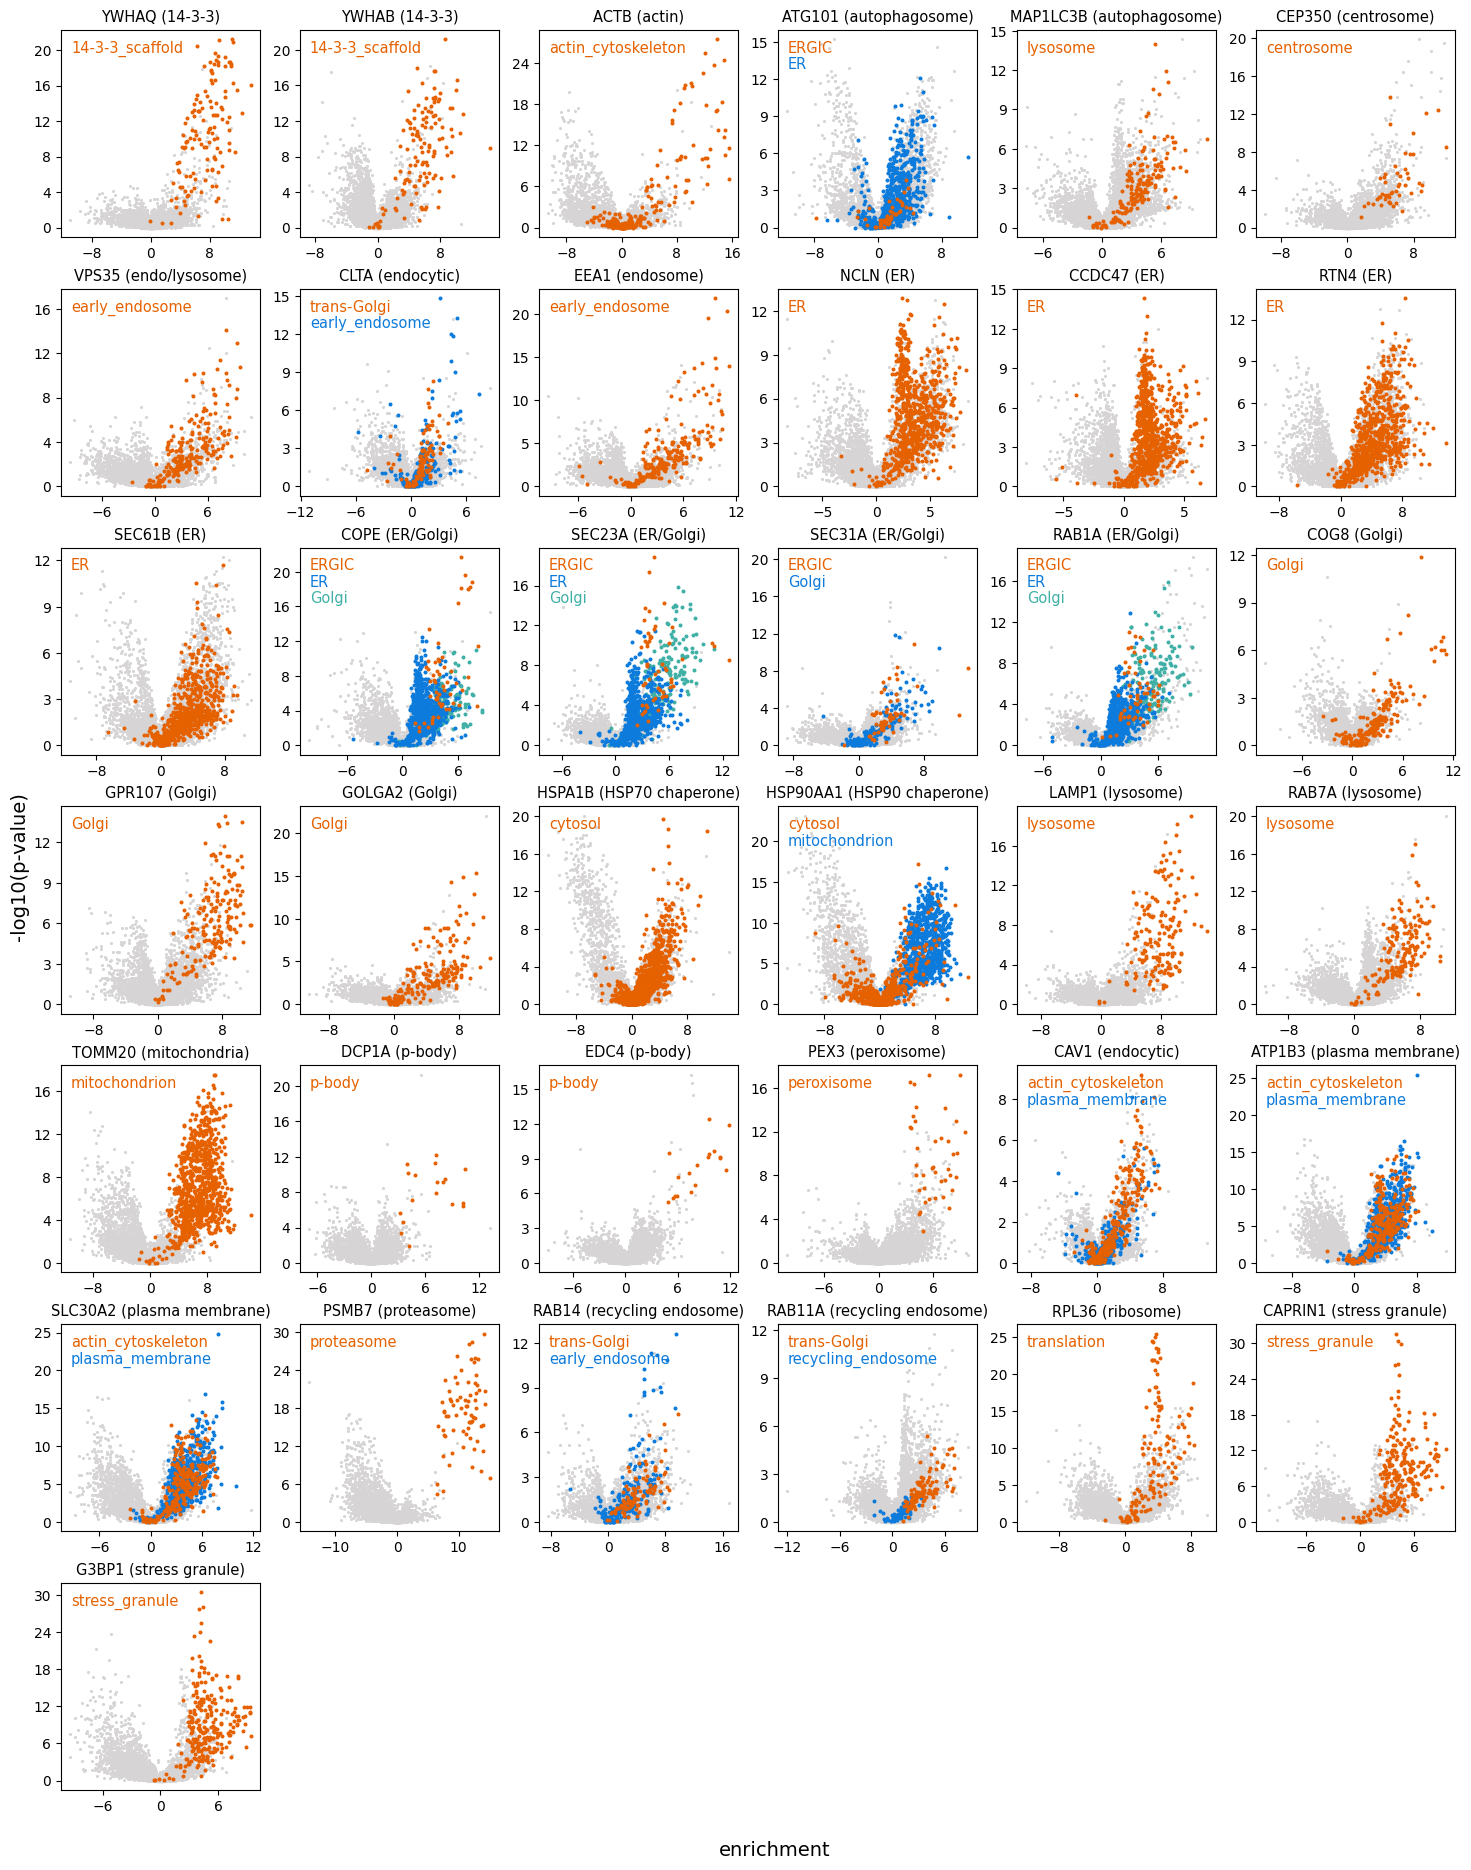

In [7]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(fig_width, fig_height)  # Set the figure size
fig.subplots_adjust(left=0.08, bottom=0.08, hspace=0.25)

verbose = False
desired_order = ["ERGIC", "cytosol"] # puts it a the end of the list, to be plotted on the top layer

idx = 0
for r in range(nrows):
    for c in range(ncols):
        # Get data for a specific pulldown
        if idx >= len(ip_name_with_comparts):
            axs[r, c].axis("off")
            continue
        n = ip_name_with_comparts[idx]
        pulldown_df = volcano_df[n].copy()
        pulldown_df.rename(columns={"pvals": " -log10(p-value)"}, inplace=True)
        pulldown_df["p-value"] = round(10 ** (-pulldown_df[" -log10(p-value)"]), 4)
        pulldown_df["Gene name canonical"] = volcano_df.loc[:, ("metadata", "Gene_name_canonical")]
        pulldown_df["consensus_graph_annnotation"] = volcano_df.loc[:, ("metadata", "consensus_graph_annnotation")]

        # Highlights
        current_highlights = cluster_highlights[idx]  # List of clusters to highlight

        # Enforce the desired plotting order
        # Remove clusters not in current_highlights and preserve order
        ordered_highlights = [cluster for cluster in desired_order if cluster in current_highlights]
        # Append any clusters in current_highlights not in desired_order at the end
        unordered_highlights = [cluster for cluster in current_highlights if cluster not in desired_order]
        current_highlights = unordered_highlights + ordered_highlights 
        print(f"{ip_name_with_comparts[idx]}, highlights: {current_highlights}") if verbose else None

        # Generate a color map for the highlighted clusters
        num_highlights = len(current_highlights)
        highlight_colors = colors_list[:num_highlights]
        highlight_colors = highlight_colors[::-1] # reverse the order of the colors
        color_mapping = dict(zip(current_highlights, highlight_colors))

        # Plot rest of the points
        rest_point_size = 1.5
        rest_df = pulldown_df[~pulldown_df["consensus_graph_annnotation"].isin(current_highlights)]
        axs[r, c].scatter(
            x=rest_df["enrichment"],
            y=rest_df[" -log10(p-value)"],
            s=rest_point_size,
            color=rest_points_color,
            rasterized=rasterized_points,
        )

        # Plot highlighted clusters with different colors
        hilighted_point_size = 3.5
        for cluster in current_highlights:
            print(f"...plotting highlight: {cluster}") if verbose else None
            cluster_df = pulldown_df[pulldown_df["consensus_graph_annnotation"] == cluster]
            axs[r, c].scatter(
                x=cluster_df["enrichment"],
                y=cluster_df[" -log10(p-value)"],
                s=hilighted_point_size,
                color=color_mapping[cluster],
                alpha=1,
                rasterized=rasterized_points,
            )

        # Set title
        axs[r, c].set_title(ip_name_with_comparts[idx], fontsize=10.5)

        # Add text annotations for highlighted clusters
        y_pos = 0.95  # Starting position for text
        line_height = 0.08  # Space between lines
        for cluster in current_highlights[::-1]:
            axs[r, c].text(
                0.05,
                y_pos,
                cluster,
                ha="left",
                va="top",
                color=color_mapping[cluster],
                transform=axs[r, c].transAxes,
                fontsize=10.5,
            )
            y_pos -= line_height

        # Force x-axis to display integer ticks
        axs[r, c].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
        # Force y-axis to display integer ticks
        axs[r, c].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))

        idx += 1

# Set a common y-axis label
fig.text(0.05, 0.5, "-log10(p-value)", va="center", rotation="vertical", fontsize=14)
# Set a common x-axis label
fig.text(0.5, 0.05, "enrichment", ha="center", fontsize=14)
# Save figure as PDF
fig.savefig(output_dir / "Suppl_fig3.svg", bbox_inches="tight", dpi=600, format="svg")
